In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import polars as pl
import seaborn as sns
from tqdm import tqdm


from river.tree import HoeffdingTreeRegressor
from river.metrics import MAE, r2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
multi_index = ['date_id', 'time_id', 'symbol_id']
feature_col = ['weight'] + [f'feature_{i:02d}' for i in range(79)]

most_na_drop = ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
                'feature_21', 'feature_26', 'feature_27', 'feature_31', ]

target = 'responder_6'

interest_col = multi_index + feature_col + [target]

resp = multi_index + [f'responder_{i:d}' for i in range(9)]
start_date = 1100

In [63]:
all_df = pl.scan_parquet('data/train.parquet')

df = all_df.select(interest_col).filter((pl.col('date_id')>=250) & (pl.col('date_id')<500)).collect()

df.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
250,0,0,1.959308,1.605457,1.320172,0.876737,0.860023,2.576464,-0.858036,0.908222,-0.018342,0.493749,11,7,76,-0.687818,0.005404,-0.454758,null,-0.152152,null,-1.226076,-1.528973,1.066293,null,0.267608,1.000074,-0.395409,-0.476566,null,null,1.374564,-0.40679,-0.445075,null,null,null,0.979148,-0.126218,-2.725279,0.178038,0.571659,null,0.595965,null,null,0.042779,null,-1.084276,1.452905,-5.010906,-0.250347,-3.353619,null,-0.53479,null,null,-1.841645,null,-3.301269,1.756481,null,-0.725097,-0.540268,-0.595326,null,0.12663,0.145206,-1.411645,-1.768889,-0.954239,0.214706,-0.609738,-0.826454,-0.255317,-0.927486,null,null,-0.229925,-0.245986,-0.263359,-0.347432,-0.12346
250,0,1,2.528334,1.877088,1.074753,1.344299,1.241382,2.919157,-1.118068,0.892507,-0.019235,0.632456,11,7,76,-0.969599,0.901654,-0.271953,null,-0.385723,null,-0.505869,-1.378434,1.039876,null,0.55961,1.027149,-0.353358,-0.491056,null,null,2.085763,-0.458888,-0.44697,null,null,null,0.457786,-0.142309,-1.887481,0.093277,0.351823,null,-0.792938,null,null,-2.146638,null,-1.967407,1.163087,-0.966226,-2.538518,-1.635712,null,0.358832,null,null,-1.109276,null,-1.652144,1.614335,null,-0.942882,-0.901017,-0.595326,0.530189,0.548535,0.794676,-1.088653,-1.09445,-1.010848,1.318943,-0.27631,-1.062749,0.225427,-0.596918,null,null,-0.257273,-0.413065,-0.369639,-0.326112,0.556318
250,0,2,1.177309,2.033435,1.737041,1.136089,1.512598,2.280757,-0.863819,0.868109,-0.011423,0.513923,81,2,59,-0.467752,-0.439651,-0.912618,null,-0.508235,null,-1.896435,-1.398048,-0.092468,null,-0.759515,-0.677455,-0.374385,-0.275821,null,null,1.088152,-0.662392,-0.415276,null,null,null,-0.246555,-1.334122,-2.676482,0.001585,0.215614,null,null,null,null,null,null,null,null,-1.133355,-4.677754,-1.953335,null,-0.476531,null,null,0.476696,null,-2.372948,2.201188,null,-0.143384,-0.156809,-0.595326,null,null,null,null,null,-0.864278,-0.260833,-0.549157,-0.791221,-0.265749,-1.165795,null,null,-1.101052,-1.407771,-1.56652,-1.111843,-0.037228
250,0,3,1.163028,1.477112,0.980013,1.066469,1.330821,2.330519,-0.779433,0.380889,-0.020649,0.349964,4,3,11,-0.630246,1.48143,-0.177156,null,-0.691552,null,-1.283815,-1.019725,0.994447,null,-0.888238,-1.137675,1.417517,1.053544,null,null,-1.274891,-0.602479,-0.402433,null,null,null,-0.040283,0.627688,1.814767,0.072605,0.207931,null,2.088032,null,null,2.665205,null,null,null,-0.477098,4.875962,2.666034,null,-1.010095,null,null,-0.299973,null,-2.45167,1.416881,null,-1.340204,-0.612219,-0.595326,null,-0.230623,-0.373612,null,null,-0.718661,2.14069,-0.003566,-0.815192,0.922046,-0.384369,null,null,1.680593,2.303189,4.68646,4.414695,0.205575
250,0,7,1.840161,0.919323,0.776246,1.255646,1.470538,2.536453,-1.232717,0.821578,-0.020381,0.566173,11,7,76,-1.093888,0.349705,

In [64]:
null_count = df.null_count().to_pandas().values.flatten()
null_ratio = null_count / len(df)

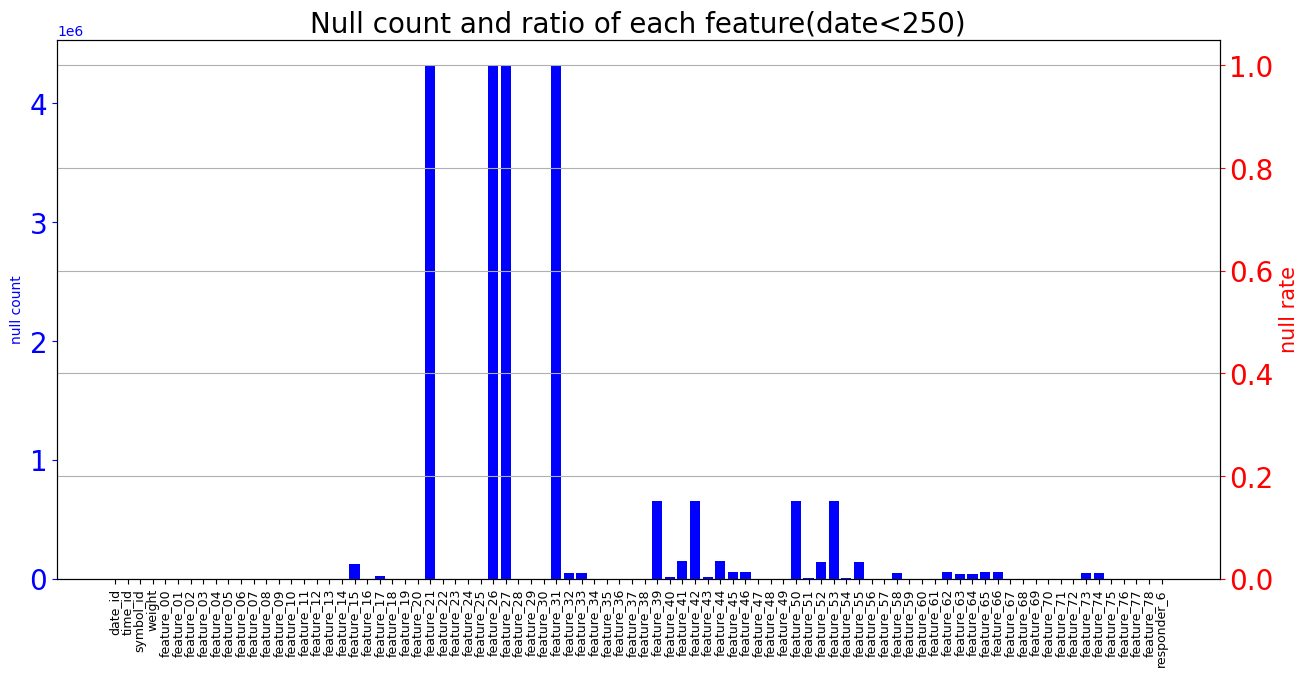

In [65]:
fig, ax1 = plt.subplots(figsize=(15, 7))

plt.bar(df.columns, null_count, color='b')
ax1.set_ylabel('null count', color='b')
ax1.tick_params('y', colors='b', labelsize=20)

ax2 = ax1.twinx()

plt.bar(df.columns, null_ratio, color='r', alpha=0)
ax2.set_ylabel('null rate', color='r',fontsize=15)
ax2.tick_params('y', colors='r', labelsize=20)

ax1.set_xticks(range(len(df.columns)))
ax1.set_xticklabels(df.columns, rotation=90, fontsize=9)

plt.title('Null count and ratio of each feature(date<250)', fontsize=20)
plt.grid()
plt.show()

In [ ]:
(df.filter((pl.col('feature_41').is_null())).group_by(['date_id', 'symbol_id'])
    .agg(pl.col("time_id").n_unique().alias("n_unique_time_ids"))
    .select(pl.col('n_unique_time_ids'))).unique()

In [53]:
np.unique((df.filter((pl.col('feature_66').is_null())).group_by(['date_id', 'symbol_id'])
    .agg(pl.col("time_id").n_unique().alias("n_unique_time_ids"))
    .select(pl.col('n_unique_time_ids'))).to_numpy(), return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 35, 66, 75],
       dtype=uint32),
 array([185, 110,  76,  65,  33,  19,  25,  20,  10,   7,   3,   5,   5,
          1,   7,   2,   6,   2,   2,   2,   4,   2,   1,   2,   2,   2,
          1,   2,   1,   1,   1,   1,   1,   1]))

In [ ]:
(df.group_by(['date_id'])
    .agg(pl.mean('feature_73').alias('mean'),pl.std('feature_73').alias('std')))\
    .head()

In [ ]:
tmp = (df
       .group_by(['date_id', 'symbol_id'])
       .agg(pl.col('responder_6').mean().alias('mean'), pl.col('responder_6').std().alias('std'))
       .sort(['date_id', 'symbol_id'])
       )
tmp.head()

In [ ]:
plt.figure(figsize=(25, 25))

for symbol in symbols:
    sym_tmp = tmp.filter(pl.col('symbol_id')==symbol)
    plt.subplot(13, 3, symbol+1)
    plt.plot(sym_tmp['date_id'].to_numpy(), sym_tmp['mean'].to_numpy(), label=f'symbol {symbol}')
    plt.legend()

plt.show()